In [76]:
setwd('/import/hd//sc')

In [3]:
getwd()

[1] "/import/hd/sc"

In [4]:
library(Seurat)

Warning message:
"package 'Seurat' was built under R version 4.2.3"
The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject



In [4]:
dir='.' 
samples=list.files( dir )
samples

[1] "OA_1"         "OA_2"         "OA_3"         "healthy_1"    "healthy_2"   
[6] "healthy_3"    "sn_OA_1"      "sn_OA_2"      "sn_healthy_1"

In [5]:
sceList = lapply(samples,function(pro){ 
 #pro=samples[1]
 folder=file.path(dir ,pro ) 
 print(pro)
 print(folder)
 print(list.files(folder))
 sce=CreateSeuratObject(counts = Read10X(folder),
 project = pro )

 return(sce)
})

[1] "OA_1"
[1] "./OA_1"
[1] "barcodes.tsv.gz" "features.tsv.gz" "matrix.mtx.gz"  
[1] "OA_2"
[1] "./OA_2"
[1] "barcodes.tsv.gz" "features.tsv.gz" "matrix.mtx.gz"  
[1] "OA_3"
[1] "./OA_3"
[1] "barcodes.tsv.gz" "features.tsv.gz" "matrix.mtx.gz"  
[1] "healthy_1"
[1] "./healthy_1"
[1] "barcodes.tsv.gz" "features.tsv.gz" "matrix.mtx.gz"  
[1] "healthy_2"
[1] "./healthy_2"
[1] "barcodes.tsv.gz" "features.tsv.gz" "matrix.mtx.gz"  
[1] "healthy_3"
[1] "./healthy_3"
[1] "barcodes.tsv.gz" "features.tsv.gz" "matrix.mtx.gz"  
[1] "sn_OA_1"
[1] "./sn_OA_1"
[1] "barcodes.tsv.gz" "features.tsv.gz" "matrix.mtx.gz"  
[1] "sn_OA_2"
[1] "./sn_OA_2"
[1] "barcodes.tsv.gz" "features.tsv.gz" "matrix.mtx.gz"  
[1] "sn_healthy_1"
[1] "./sn_healthy_1"
[1] "barcodes.tsv.gz" "features.tsv.gz" "matrix.mtx.gz"  


In [6]:
single.ob=merge(sceList[[1]],sceList[2:length(sceList)])

Warning message in CheckDuplicateCellNames(object.list = objects):
"Some cell names are duplicated across objects provided. Renaming to enforce unique cell names."


In [7]:
single.ob

An object of class Seurat 
61134 features across 105786 samples within 1 assay 
Active assay: RNA (61134 features, 0 variable features)

In [8]:
immune.combined = single.ob

In [9]:
immune.combined[["percent.mt"]] <- PercentageFeatureSet(immune.combined,pattern = "^MT-")

In [4]:
immune.combined = readRDS('./scRNA.rds')

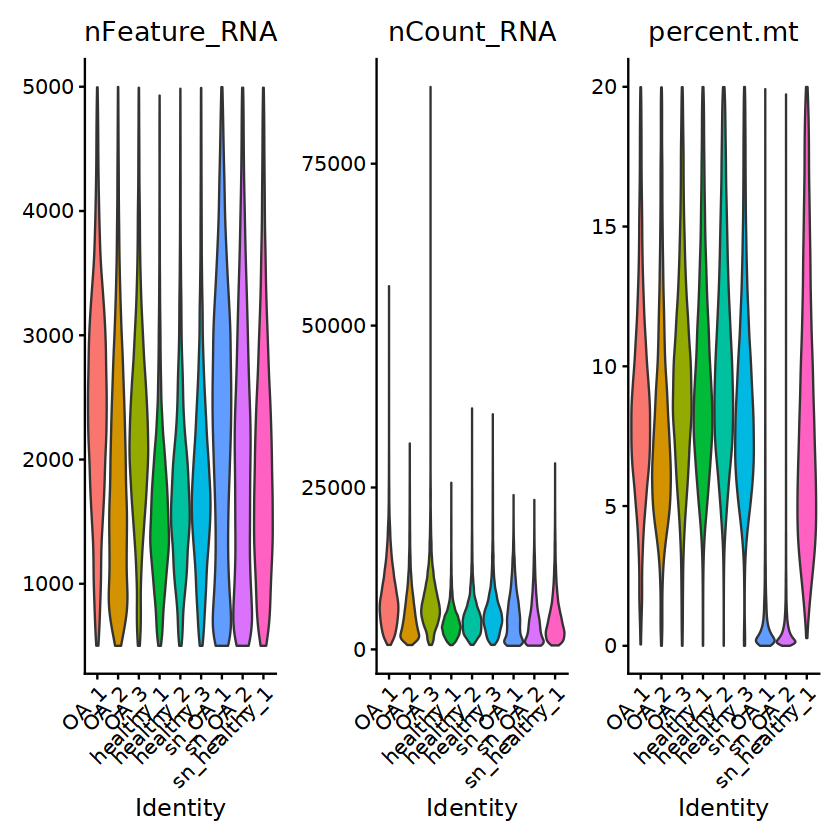

In [5]:
VlnPlot(immune.combined, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3,pt.size = 0,group.by="orig.ident")

In [9]:
library(ggplot2)

Warning message:
"package 'ggplot2' was built under R version 4.2.3"


In [10]:
ggsave('../figure2/QC.pdf',width = 12,height = 5)

In [11]:
library(ggplot2)

Warning message:
"package 'ggplot2' was built under R version 4.2.3"


In [12]:
ggsave('figure1.pdf',height =  4,width = 9)

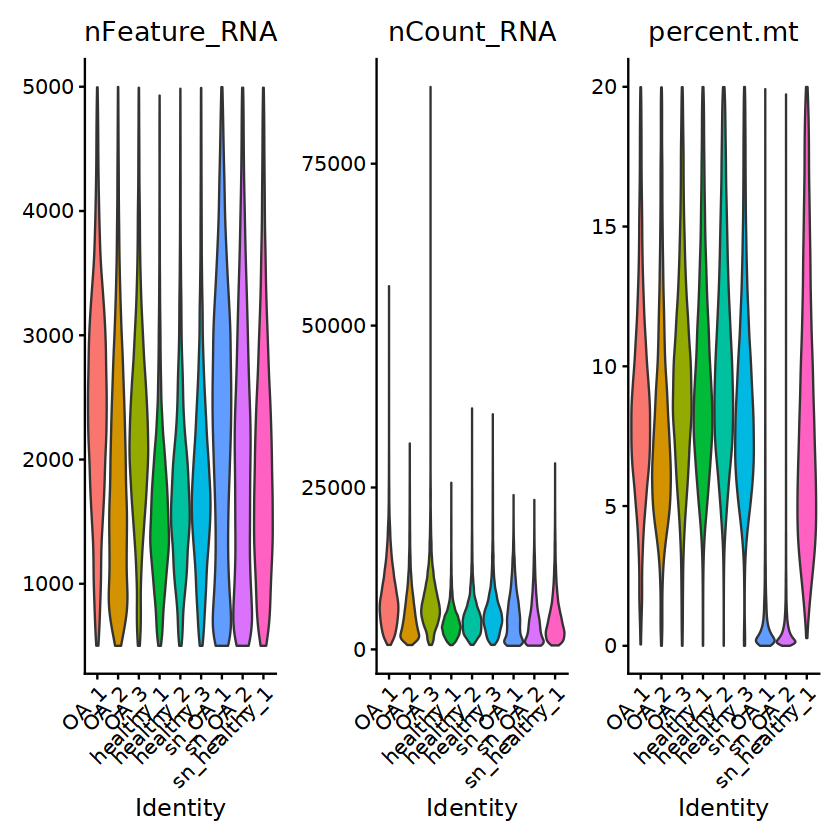

In [13]:
immune.combined <-   subset(immune.combined, subset = nFeature_RNA > 500 & nFeature_RNA < 5000 & percent.mt < 20)
VlnPlot(immune.combined, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3,pt.size = 0,group.by="orig.ident")
ggsave('figure1-1.pdf',height =  4,width = 9)

In [14]:
table(immune.combined$orig.ident)


        OA_1         OA_2         OA_3    healthy_1    healthy_2    healthy_3 
        9169        10914         8697        11700        11449        10005 
     sn_OA_1      sn_OA_2 sn_healthy_1 
       10034         7487         9417 

### 去除双细胞

In [15]:
library(DoubletFinder)
library(tidyverse)
library(Seurat)
library(patchwork)

Warning message:
"package 'tibble' was built under R version 4.2.3"
Warning message:
"package 'tidyr' was built under R version 4.2.3"
Warning message:
"package 'readr' was built under R version 4.2.3"
Warning message:
"package 'purrr' was built under R version 4.2.3"
Warning message:
"package 'stringr' was built under R version 4.2.3"
Warning message:
"package 'forcats' was built under R version 4.2.3"
Warning message:
"package 'lubridate' was built under R version 4.2.3"
Warning message in system("timedatectl", intern = TRUE):
"running command 'timedatectl' had status 1"
-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v lubridate 1.9.2     v tibble    3.2.1
v purrr     1.0.2     v tidyr     1.3.1
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted 

In [16]:
immune.combined <-NormalizeData(immune.combined)
immune.combined <- ScaleData(immune.combined,feature=rownames(immune.combined), verbose = FALSE)
immune.combined <- FindVariableFeatures(object = immune.combined,selection.method = 'vst', nfeatures = 2000)
immune.combined <- RunPCA(immune.combined,  features = VariableFeatures(object = immune.combined) ,verbose = FALSE)
immune.combined <- RunUMAP(immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- RunTSNE(immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- FindNeighbors(immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- FindClusters(immune.combined)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
07:24:22 UMAP embedding parameters a = 0.9922 b = 1.112

07:24:22 Read 88872 rows and found 20 numeric columns

07:24:22 Using Annoy for neighbor search, n_neighbors = 30

07:24:22 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

07:24:35 Writing NN index file to temp file /tmp/RtmpdckbCf/file581c68bf5cda

07:24:35 Searching Annoy index using 1 thread, search_k = 3000

07:25:03 Annoy recall = 100%

07:25:04 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 88872
Number of edges: 3111508

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9469
Number of communities: 42
Elapsed time: 64 seconds


In [17]:
H9 = immune.combined

In [18]:
paramSweep = function (seu, PCs = 1:20, sct = FALSE, num.cores = 1) 
{
    require(Seurat)
    require(fields)
    require(parallel)
    pK <- c(5e-04, 0.001, 0.005, seq(0.01, 0.3, by = 0.01))
    pN <- seq(0.05, 0.3, by = 0.05)
    min.cells <- round(nrow(seu@meta.data)/(1 - 0.05) - nrow(seu@meta.data))
    pK.test <- round(pK * min.cells)
    pK <- pK[which(pK.test >= 1)]
    orig.commands <- seu@commands
    if (nrow(seu@meta.data) > 10000) {
        real.cells <- rownames(seu@meta.data)[sample(1:nrow(seu@meta.data), 
            10000, replace = FALSE)]
        data <- seu@assays$RNA@counts[, real.cells]
        n.real.cells <- ncol(data)
    }
    if (nrow(seu@meta.data) <= 10000) {
        real.cells <- rownames(seu@meta.data)
        data <- seu@assays$RNA@counts
        n.real.cells <- ncol(data)
    }
    if (num.cores > 1) {
        require(parallel)
        cl <- makeCluster(num.cores)
        output2 <- mclapply(as.list(1:length(pN)), FUN = parallel_paramSweep, 
            n.real.cells, real.cells, pK, pN, data, orig.commands, 
            PCs, sct, mc.cores = num.cores)
        stopCluster(cl)
    }
    else {
        output2 <- lapply(as.list(1:length(pN)), FUN = parallel_paramSweep, 
            n.real.cells, real.cells, pK, pN, data, orig.commands, 
            PCs, sct)
    }
    sweep.res.list <- list()
    list.ind <- 0
    for (i in 1:length(output2)) {
        for (j in 1:length(output2[[i]])) {
            list.ind <- list.ind + 1
            sweep.res.list[[list.ind]] <- output2[[i]][[j]]
        }
    }
    name.vec <- NULL
    for (j in 1:length(pN)) {
        name.vec <- c(name.vec, paste("pN", pN[j], "pK", pK, 
            sep = "_"))
    }
    names(sweep.res.list) <- name.vec
    return(sweep.res.list)
}

In [ ]:
sweep.res.list_kidney <- paramSweep(H9, PCs = 1:20, sct = FALSE)

Loading required package: fields

Loading required package: spam

Spam version 2.10-0 (2023-10-23) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: 'spam'


The following objects are masked from 'package:base':

    backsolve, forwardsolve


Loading required package: viridisLite

Warning message:
"package 'viridisLite' was built under R version 4.2.3"

Try help(fields) to get started.

Loading required package: parallel



[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



In [ ]:
sweep.stats_kidney <- summarizeSweep(sweep.res.list_kidney, GT = FALSE)
bcmvn_kidney <- find.pK(sweep.stats_kidney)

In [ ]:
pK_bcmvn <- bcmvn_kidney$pK[which.max(bcmvn_kidney$BCmetric)] %>% as.character() %>% as.numeric()

In [ ]:
DoubletRate = ncol(H9)*8*1e-7

In [ ]:
DoubletRate

In [ ]:
homotypic.prop <- modelHomotypic(H9$orig.ident)

In [ ]:
nExp_poi <- round(DoubletRate*ncol(H9)) 
nExp_poi.adj <- round(nExp_poi*(1-homotypic.prop))

In [ ]:
doubletFinder = function (seu, PCs, pN = 0.25, pK, nExp, reuse.pANN = FALSE, 
    sct = FALSE, annotations = NULL) 
{
    require(Seurat)
    require(fields)
    require(KernSmooth)
    if (reuse.pANN != FALSE) {
        pANN.old <- seu@meta.data[, reuse.pANN]
        classifications <- rep("Singlet", length(pANN.old))
        classifications[order(pANN.old, decreasing = TRUE)[1:nExp]] <- "Doublet"
        seu@meta.data[, paste("DF.classifications", pN, pK, nExp, 
            sep = "_")] <- classifications
        return(seu)
    }
    if (reuse.pANN == FALSE) {
        real.cells <- rownames(seu@meta.data)
        data <- seu@assays$RNA@counts[, real.cells]
        n_real.cells <- length(real.cells)
        n_doublets <- round(n_real.cells/(1 - pN) - n_real.cells)
        print(paste("Creating", n_doublets, "artificial doublets...", 
            sep = " "))
        real.cells1 <- sample(real.cells, n_doublets, replace = TRUE)
        real.cells2 <- sample(real.cells, n_doublets, replace = TRUE)
        doublets <- (data[, real.cells1] + data[, real.cells2])/2
        colnames(doublets) <- paste("X", 1:n_doublets, sep = "")
        data_wdoublets <- cbind(data, doublets)
        if (!is.null(annotations)) {
            stopifnot(typeof(annotations) == "character")
            stopifnot(length(annotations) == length(Cells(seu)))
            stopifnot(!any(is.na(annotations)))
            annotations <- factor(annotations)
            names(annotations) <- Cells(seu)
            doublet_types1 <- annotations[real.cells1]
            doublet_types2 <- annotations[real.cells2]
        }
        orig.commands <- seu@commands
        if (sct == FALSE) {
            print("Creating Seurat object...")
            seu_wdoublets <- CreateSeuratObject(counts = data_wdoublets)
            print("Normalizing Seurat object...")
            seu_wdoublets <- NormalizeData(seu_wdoublets, normalization.method = orig.commands$NormalizeData.RNA@params$normalization.method, 
                scale.factor = orig.commands$NormalizeData.RNA@params$scale.factor, 
                margin = orig.commands$NormalizeData.RNA@params$margin)
            print("Finding variable genes...")
            seu_wdoublets <- FindVariableFeatures(seu_wdoublets, 
                selection.method = orig.commands$FindVariableFeatures.RNA$selection.method, 
                loess.span = orig.commands$FindVariableFeatures.RNA$loess.span, 
                clip.max = orig.commands$FindVariableFeatures.RNA$clip.max, 
                mean.function = orig.commands$FindVariableFeatures.RNA$mean.function, 
                dispersion.function = orig.commands$FindVariableFeatures.RNA$dispersion.function, 
                num.bin = orig.commands$FindVariableFeatures.RNA$num.bin, 
                binning.method = orig.commands$FindVariableFeatures.RNA$binning.method, 
                nfeatures = orig.commands$FindVariableFeatures.RNA$nfeatures, 
                mean.cutoff = orig.commands$FindVariableFeatures.RNA$mean.cutoff, 
                dispersion.cutoff = orig.commands$FindVariableFeatures.RNA$dispersion.cutoff)
            print("Scaling data...")
            seu_wdoublets <- ScaleData(seu_wdoublets, features = orig.commands$ScaleData.RNA$features, 
                model.use = orig.commands$ScaleData.RNA$model.use, 
                do.scale = orig.commands$ScaleData.RNA$do.scale, 
                do.center = orig.commands$ScaleData.RNA$do.center, 
                scale.max = orig.commands$ScaleData.RNA$scale.max, 
                block.size = orig.commands$ScaleData.RNA$block.size, 
                min.cells.to.block = orig.commands$ScaleData.RNA$min.cells.to.block)
            print("Running PCA...")
            seu_wdoublets <- RunPCA(seu_wdoublets, features = orig.commands$ScaleData.RNA$features, 
                npcs = length(PCs), rev.pca = orig.commands$RunPCA.RNA$rev.pca, 
                weight.by.var = orig.commands$RunPCA.RNA$weight.by.var, 
                verbose = FALSE)
            pca.coord <- seu_wdoublets@reductions$pca@cell.embeddings[, 
                PCs]
            cell.names <- rownames(seu_wdoublets@meta.data)
            nCells <- length(cell.names)
            rm(seu_wdoublets)
            gc()
        }
        if (sct == TRUE) {
            require(sctransform)
            print("Creating Seurat object...")
            seu_wdoublets <- CreateSeuratObject(counts = data_wdoublets)
            print("Running SCTransform...")
            seu_wdoublets <- SCTransform(seu_wdoublets)
            print("Running PCA...")
            seu_wdoublets <- RunPCA(seu_wdoublets, npcs = length(PCs))
            pca.coord <- seu_wdoublets@reductions$pca@cell.embeddings[, 
                PCs]
            cell.names <- rownames(seu_wdoublets@meta.data)
            nCells <- length(cell.names)
            rm(seu_wdoublets)
            gc()
        }
        print("Calculating PC distance matrix...")
        dist.mat <- fields::rdist(pca.coord)
        print("Computing pANN...")
        pANN <- as.data.frame(matrix(0L, nrow = n_real.cells, 
            ncol = 1))
        if (!is.null(annotations)) {
            neighbor_types <- as.data.frame(matrix(0L, nrow = n_real.cells, 
                ncol = length(levels(doublet_types1))))
        }
        rownames(pANN) <- real.cells
        colnames(pANN) <- "pANN"
        k <- round(nCells * pK)
        for (i in 1:n_real.cells) {
            neighbors <- order(dist.mat[, i])
            neighbors <- neighbors[2:(k + 1)]
            pANN$pANN[i] <- length(which(neighbors > n_real.cells))/k
            if (!is.null(annotations)) {
                for (ct in unique(annotations)) {
                  neighbors_that_are_doublets = neighbors[neighbors > 
                    n_real.cells]
                  if (length(neighbors_that_are_doublets) > 0) {
                    neighbor_types[i, ] <- table(doublet_types1[neighbors_that_are_doublets - 
                      n_real.cells]) + table(doublet_types2[neighbors_that_are_doublets - 
                      n_real.cells])
                    neighbor_types[i, ] <- neighbor_types[i, 
                      ]/sum(neighbor_types[i, ])
                  }
                  else {
                    neighbor_types[i, ] <- NA
                  }
                }
            }
        }
        print("Classifying doublets..")
        classifications <- rep("Singlet", n_real.cells)
        classifications[order(pANN$pANN[1:n_real.cells], decreasing = TRUE)[1:nExp]] <- "Doublet"
        seu@meta.data[, paste("pANN", pN, pK, nExp, sep = "_")] <- pANN[rownames(seu@meta.data), 
            1]
        seu@meta.data[, paste("DF.classifications", pN, pK, nExp, 
            sep = "_")] <- classifications
        if (!is.null(annotations)) {
            colnames(neighbor_types) = levels(doublet_types1)
            for (ct in levels(doublet_types1)) {
                seu@meta.data[, paste("DF.doublet.contributors", 
                  pN, pK, nExp, ct, sep = "_")] <- neighbor_types[, 
                  ct]
            }
        }
        return(seu)
    }
}

In [ ]:
scRNA <- doubletFinder(H9, PCs = 1:20, pN = 0.25, pK = pK_bcmvn, 
                          nExp = nExp_poi.adj, reuse.pANN = F, sct = F)

In [ ]:
colnames(scRNA@meta.data)

In [ ]:
DimPlot(scRNA, reduction = "umap", group.by = "DF.classifications_0.25_0.21_2551")

In [ ]:
ggsave('figure2.pdf',height =  4,width = 5)

In [ ]:
immune.combined = subset(scRNA, subset = DF.classifications_0.25_0.21_2551  != 'Doublet')

In [ ]:
immune.combined <-   subset(immune.combined, subset = nFeature_RNA > 500 & nFeature_RNA < 5000 & percent.mt < 10)
VlnPlot(immune.combined, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3,pt.size = 0,group.by="orig.ident")
ggsave('figure1-1.pdf',height =  4,width = 9)

In [ ]:
table(immune.combined$orig.ident)

In [ ]:
# ifnb.list <- SplitObject(immune.combined, split.by = "orig.ident")

# testAB.anchors <- FindIntegrationAnchors(object.list = ifnb.list, dims = 1:20)
# testAB.integrated <- IntegrateData(anchorset = testAB.anchors, dims = 1:20)

# DefaultAssay(testAB.integrated) <- "integrated"
# # Run the standard workflow for visualization and clustering
# testAB.integrated <- ScaleData(testAB.integrated, features = rownames(testAB.integrated))
# testAB.integrated <- RunPCA(testAB.integrated, npcs = 50, verbose = FALSE)
# testAB.integrated <- FindNeighbors(testAB.integrated, dims = 1:30)
# testAB.integrated <- FindClusters(testAB.integrated, resolution = 0.5)
# testAB.integrated <- RunUMAP(testAB.integrated, dims = 1:30)
# testAB.integrated <- RunTSNE(testAB.integrated, dims = 1:30)

# immune.combined = testAB.integrated

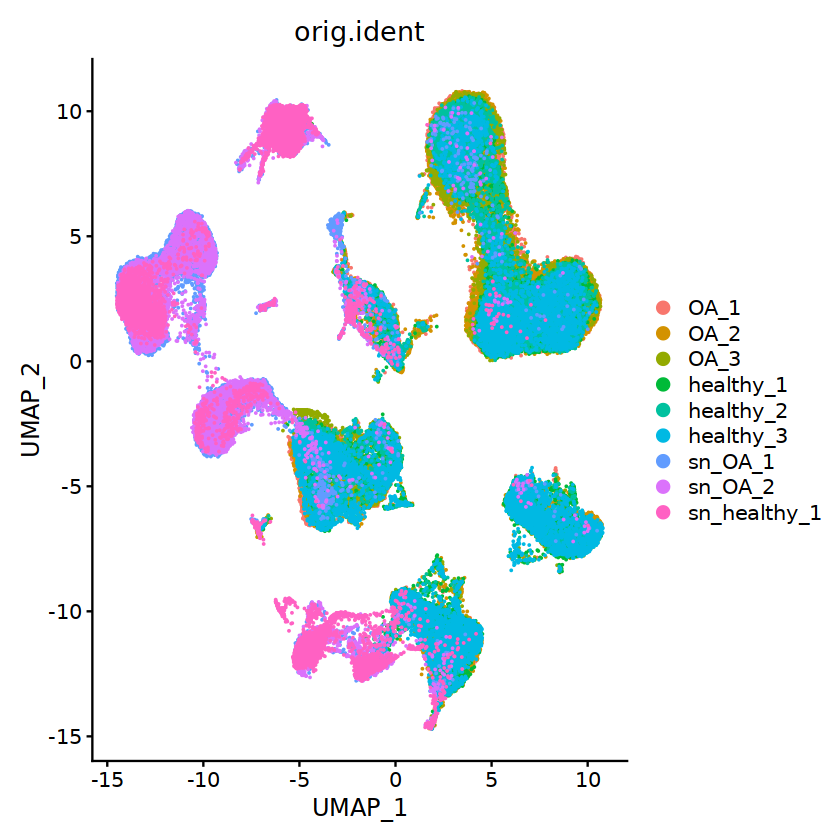

In [12]:
DimPlot(immune.combined, reduction = "umap", group.by = "orig.ident")

In [13]:
ggsave(file = '../figure2/fig1.umap.sample.pdf',width = 7,height = 5)

In [33]:
saveRDS(immune.combined,file = 'before_rename.rds')

In [34]:
ggsave('figure3.pdf',height =  4,width = 5)

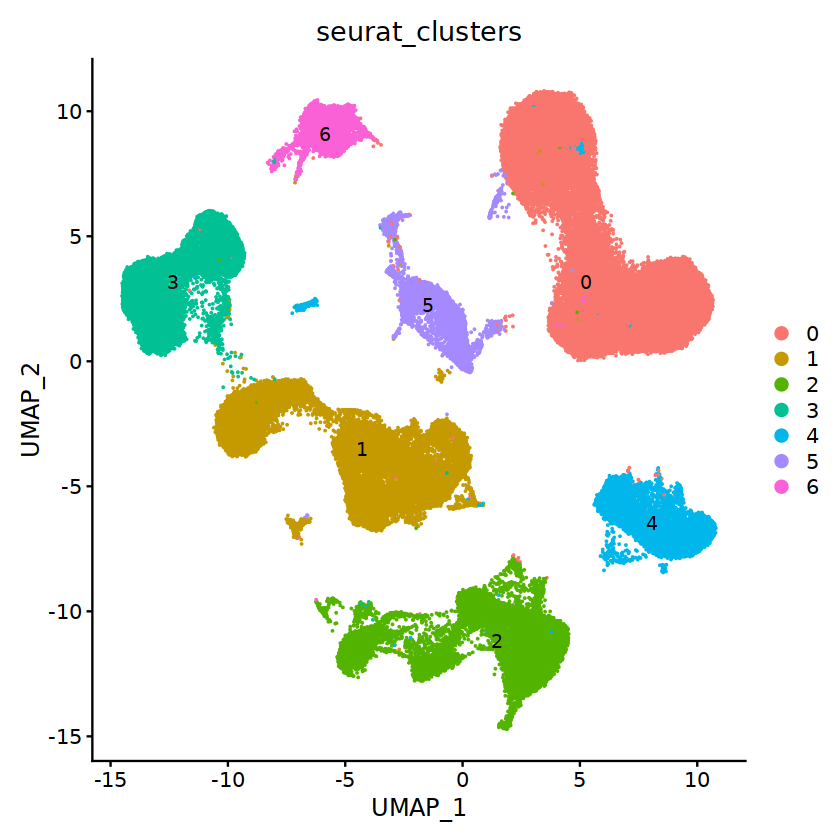

In [14]:
DimPlot(immune.combined, reduction = "umap", group.by  = "seurat_clusters",label = T)

In [15]:
ggsave(file = '../figure2/fig2.umap.cluster.pdf',width = 6,height = 5)

In [36]:
ggsave('figure4.pdf',height =  8,width = 12)

In [37]:
immune.combined = readRDS('./before_rename.rds')

In [38]:
library(harmony)
DefaultAssay(immune.combined) = 'RNA'
sceList <- SplitObject(immune.combined, split.by = "orig.ident")
single.ob=merge(sceList[[1]],sceList[2:length(sceList)])
DefaultAssay(single.ob) = 'RNA'
scRNA_harmony = single.ob
scRNA_harmony <- NormalizeData(scRNA_harmony) %>% FindVariableFeatures() %>% ScaleData() %>% RunPCA(verbose=FALSE)
##整合
system.time({scRNA_harmony <- RunHarmony(scRNA_harmony, group.by.vars = "orig.ident")})
scRNA_harmony <- RunUMAP(scRNA_harmony, reduction = "harmony", dims = 1:30)


Loading required package: Rcpp

Warning message:
"package 'Rcpp' was built under R version 4.2.3"
Centering and scaling data matrix

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations

Warning message:
"Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity"


   user  system elapsed 
 58.034  28.618  54.426 

10:35:33 UMAP embedding parameters a = 0.9922 b = 1.112

10:35:33 Read 88872 rows and found 30 numeric columns

10:35:33 Using Annoy for neighbor search, n_neighbors = 30

10:35:33 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:35:43 Writing NN index file to temp file /tmp/RtmpdckbCf/file581c61f17cfb

10:35:43 Searching Annoy index using 1 thread, search_k = 3000

10:36:14 Annoy recall = 100%

10:36:15 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

10:36:18 Initializing from normalized Laplacian + noise (using irlba)

10:36:57 Commencing optimization for 200 epochs, with 4080952 positive edges

10:38:34 Optimization finished



In [79]:
scRNA_harmony <- FindNeighbors(scRNA_harmony, reduction = "harmony", dims = 1:30) %>% FindClusters(resolution =  0.01)
##作图
#group_by_cluster
options(repr.plot.width = 12,repr.plot.height = 8)
table(scRNA_harmony$orig.ident)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 88872
Number of edges: 3288087

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9964
Number of communities: 7
Elapsed time: 78 seconds



        OA_1         OA_2         OA_3    healthy_1    healthy_2    healthy_3 
        9169        10914         8697        11700        11449        10005 
     sn_OA_1      sn_OA_2 sn_healthy_1 
       10034         7487         9417 

In [80]:
Idents(scRNA_harmony) = 'seurat_clusters'

In [81]:
#scRNA_harmony = subset(scRNA_harmony,idents = c(0,1,2,3,4,5))

In [82]:
scRNA_harmony$group = ifelse(scRNA_harmony$orig.ident %in%  c('OA_1','OA_2','OA_3','sn_OA_1','sn_OA_2'),'OA','Healthy')

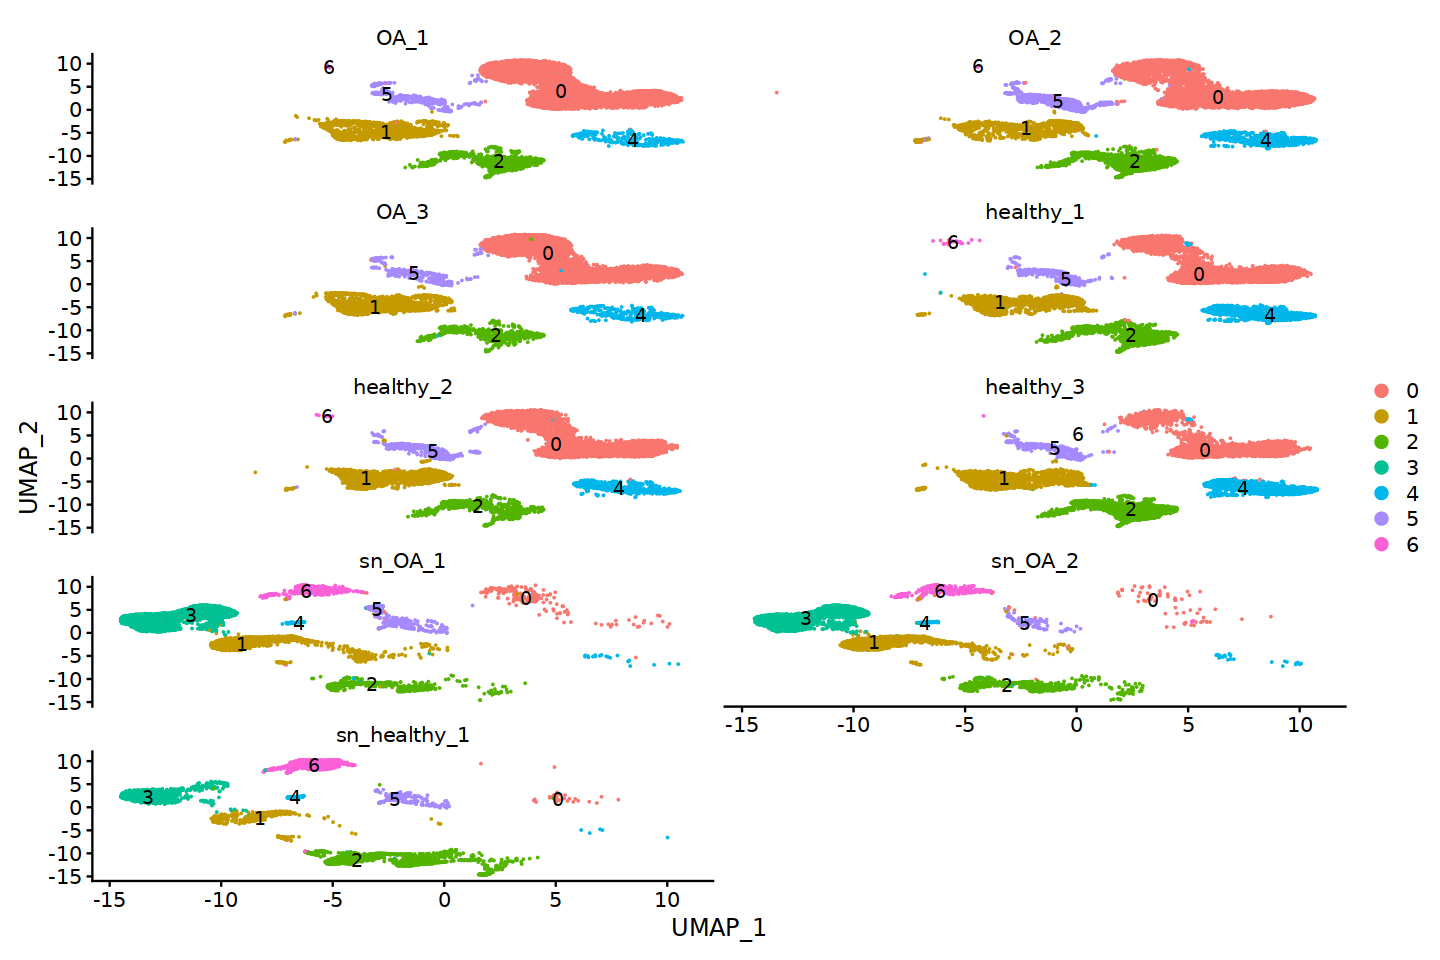

In [83]:
DimPlot(scRNA_harmony, reduction = "umap", split.by = "orig.ident",ncol = 2,label = T)

In [16]:
Idents(immune.combined) = 'celltype'

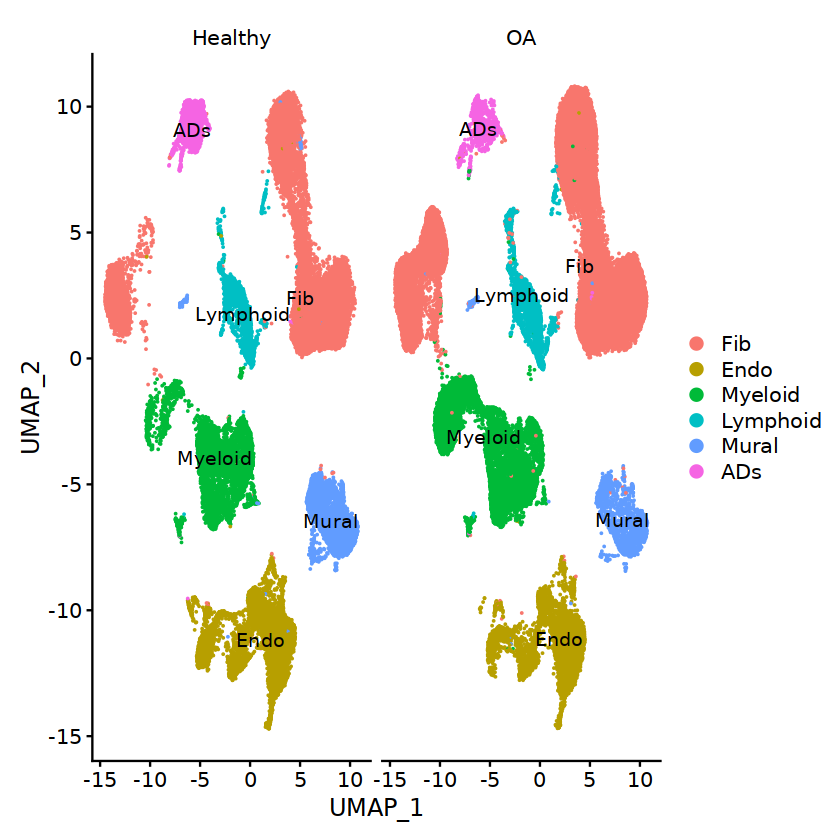

In [17]:
DimPlot(immune.combined, reduction = "umap", split.by = "group",ncol = 2,label = T)

In [18]:
ggsave(file = '../figure2/fig3.umap.group.pdf',width = 10,height = 5)

In [19]:
scRNA_harmony = immune.combined

In [20]:
DefaultAssay(scRNA_harmony) = 'RNA'

In [21]:
Idents(scRNA_harmony) = 'seurat_clusters'

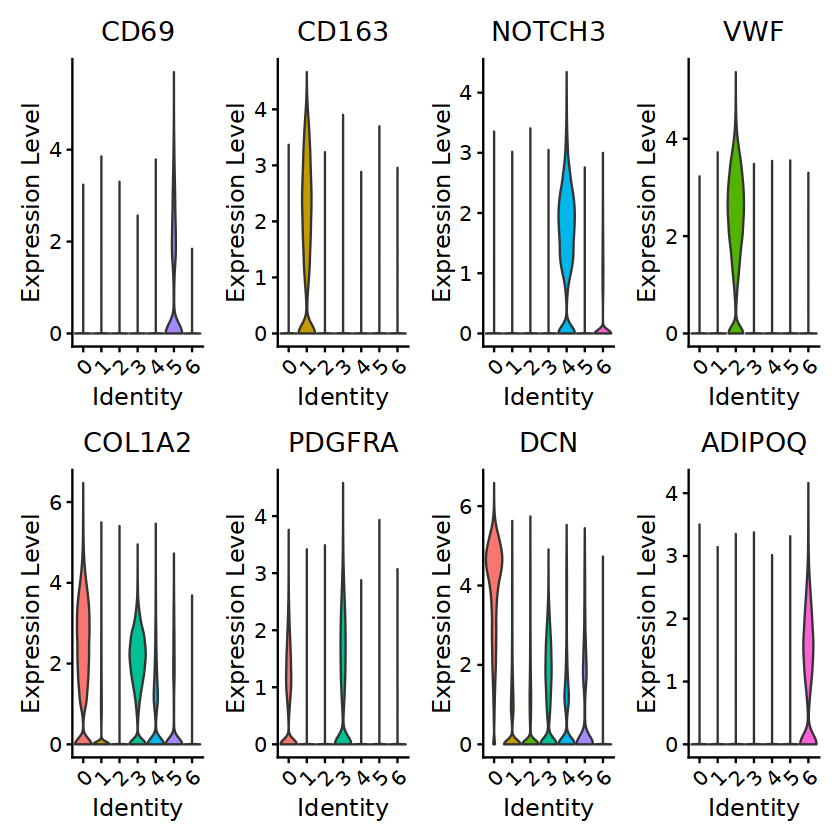

In [23]:
VlnPlot(scRNA_harmony,features = c('CD69','CD163','NOTCH3','VWF','COL1A2','PDGFRA','DCN','ADIPOQ'),pt.size = 0,ncol = 4)

In [24]:
ggsave(file = '../figure2/fig4.vlnplot.marker.pdf',width = 9,height = 8)

In [89]:
scRNA = scRNA_harmony

In [90]:
library(Seurat) ##
library(SingleR)
library(ggplot2)
library(reshape2)
mouseImmu  = get(load('/import/DB/SingleR_ref/ref_Human_all.RData'))

In [91]:
pbmc_for_SingleR <- GetAssayData(scRNA, slot="data") ##获取标准化矩阵
clusters=scRNA@meta.data$seurat_clusters

In [92]:
pred.mouseImmu <- SingleR(test = pbmc_for_SingleR, ref = mouseImmu, labels = mouseImmu$label.main,
 method = "cluster", clusters = clusters, 
 assay.type.test = "logcounts", assay.type.ref = "logcounts")
celltype = data.frame(ClusterID=rownames(pred.mouseImmu), celltype=pred.mouseImmu$labels, stringsAsFactors = FALSE)

Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames =

In [93]:
celltype$celltype = c('Fib','Myeloid','Endo','Fib','Mural','Lymphoid','ADs')

In [94]:
scRNA@meta.data$celltype = "NA"
# 赋值
for(i in 1:nrow(celltype)){
  scRNA@meta.data[which(scRNA@meta.data$seurat_clusters == celltype$ClusterID[i]),'celltype'] <- celltype$celltype[i]}

In [95]:
table(scRNA$celltype,scRNA$seurat_clusters)

          
               0     1     2     3     4     5     6
  ADs          0     0     0     0     0     0  4025
  Endo         0     0 12465     0     0     0     0
  Fib      33691     0     0 11198     0     0     0
  Lymphoid     0     0     0     0     0  5107     0
  Mural        0     0     0     0  6472     0     0
  Myeloid      0 15914     0     0     0     0     0

In [96]:
saveRDS(scRNA,file = 'scRNA.rds')

In [5]:
scRNA = readRDS('./scRNA.rds')

In [6]:
Idents(scRNA) = 'celltype'

sce.markers <- FindAllMarkers(object = scRNA, only.pos = TRUE, 
                              min.pct = 0.25, 
                              thresh.use = 0.25)
 library(dplyr) 
# 不同seurat版本的 avg_logFC 不一样 
top5 <- sce.markers %>% group_by(cluster) %>% top_n(5, avg_log2FC)

Calculating cluster Fib

Calculating cluster Endo

Calculating cluster Myeloid

Calculating cluster Lymphoid

Calculating cluster Mural

Calculating cluster ADs


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [ ]:
write.csv(sce.markers,file = '../figure2/sce.markers.csv')

In [99]:
library(tidyverse)

In [ ]:
library(reshape2)
a = sce.markers %>% pivot_wider( names_from = cluster, values_from = gene)

list1 <- as.list(a[,6:11])


my_list_no_na <- lapply(list1, unique)

save(my_list_no_na,file = 'my_list_no_na.rda')

In [5]:
library(Seurat)

Warning message:
"package 'Seurat' was built under R version 4.2.3"
Attaching SeuratObject



In [6]:
DefaultAssay(scRNA) ='RNA'

In [7]:
Idents(scRNA) = 'celltype'

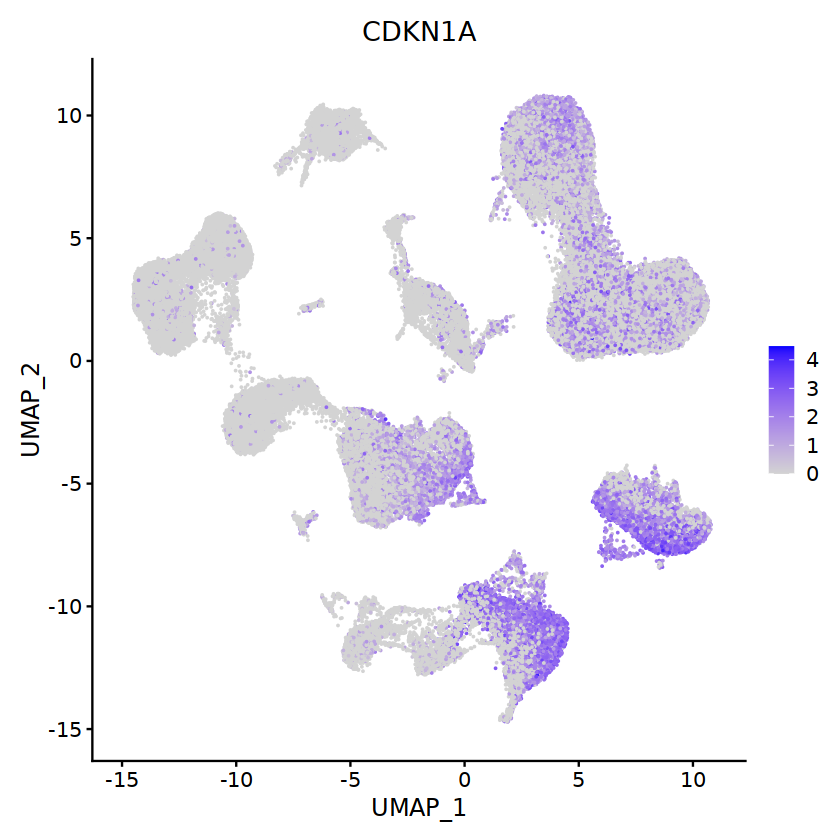

In [9]:
FeaturePlot(scRNA, features = 'CDKN1A')

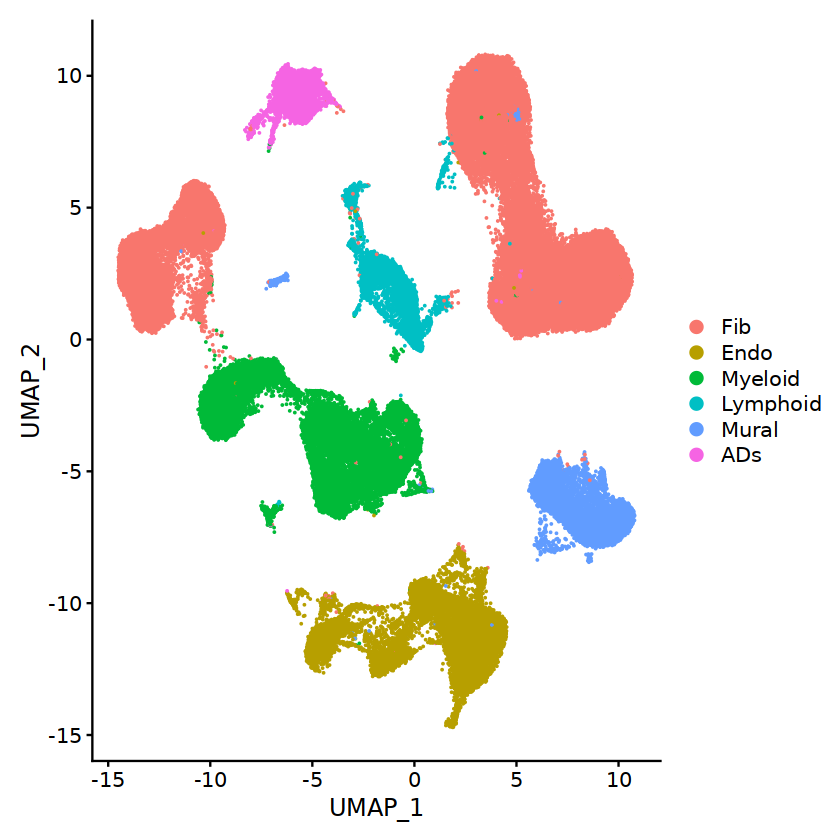

In [10]:
DimPlot(scRNA)

In [8]:
# 不同seurat版本的 avg_logFC 不一样 
top5 <- sce.markers %>% group_by(cluster) %>% top_n(10, avg_log2FC)

In [33]:

gene_cell_exp <- AverageExpression(scRNA,
                                   features = unique(top5$gene),
                                   group.by = 'celltype',
                                   slot = 'data') 
gene_cell_exp <- as.data.frame(gene_cell_exp$RNA)

In [35]:
gene_cell_exp = gene_cell_exp[,c('Fib','Endo','Myeloid','Lymphoid','Mural','ADs')]

In [36]:
head(gene_cell_exp,2)

,Fib,Endo,Myeloid,Lymphoid,Mural,ADs
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PLA2G2A,70.77652,4.219950,4.493280,7.786053,5.419029,1.8719932
DCN,63.68874,4.164765,3.928018,6.956160,5.928493,0.7923447


In [57]:
library(ComplexHeatmap)
#顶部细胞类型注释
df <- data.frame(colnames(gene_cell_exp))
colnames(df) <- 'class'

In [58]:
df$class = factor(df$class,levels =  c('Fib','Endo','Myeloid','Lymphoid','Mural','ADs'))

In [59]:


top_anno = HeatmapAnnotation(df = df,#细胞名/cluster
                             border = T,
                             show_annotation_name = F,
                             gp = gpar(col = 'black'),
                             col = list(class = c( 'Fib'="#2F528F", 'Endo'="#F6F5B4",  "Myeloid"="#067756",
                                                  "Lymphoid"="#E3AD68",   "Mural"="#ACD45E",'ADs'="#9ECABE")))#颜色设置

In [60]:
#数据标准化缩放一下
marker_exp <- t(scale(t(gene_cell_exp),scale = T,center = T))

In [61]:
head(marker_exp)

,Fib,Endo,Myeloid,Lymphoid,Mural,ADs
PLA2G2A,2.036120,-0.4271395,-0.4170235,-0.2951579,-0.3827616,-0.5140374
DCN,2.033578,-0.4144966,-0.4242334,-0.2996934,-0.3419588,-0.5531960
APOD,2.031544,-0.3400295,-0.4475341,-0.4350254,-0.2622266,-0.5467284
PRG4,2.019950,-0.4898431,-0.3717960,-0.1472135,-0.4392351,-0.5718619
LUM,2.024617,-0.4427089,-0.4044598,-0.1740335,-0.4399095,-0.5635055
CFD,2.024365,-0.5172587,-0.2462750,-0.3860682,-0.2923189,-0.5824438


In [79]:
options(repr.plot.height = 10,repr.plot.width = 7)

In [77]:
pdf('../figure2/daqunheatmap.pdf',height = 10,width = 7)

null device 
          1

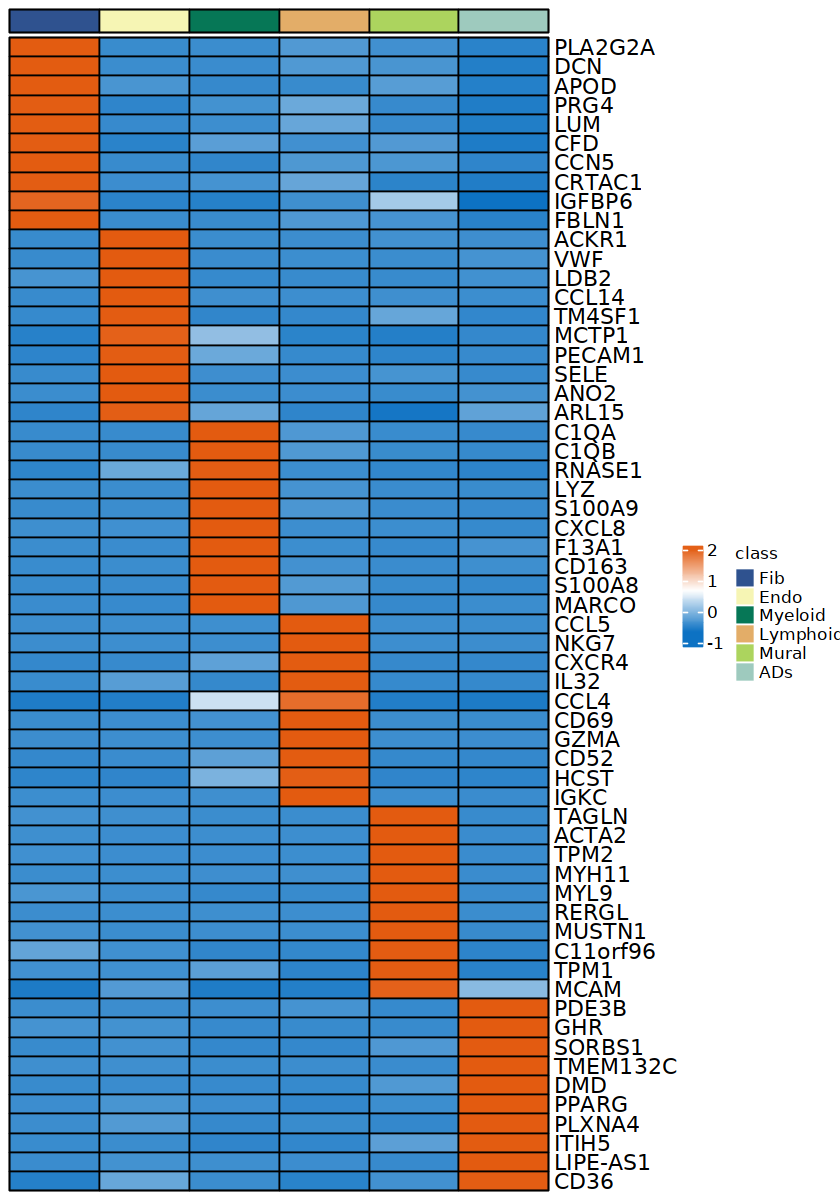

In [80]:
Heatmap(marker_exp,
        cluster_rows = F,
        cluster_columns = F,
        show_column_names = F,
        show_row_names = T,
        column_title = NULL,
        heatmap_legend_param = list(
          title=' '),
        col = colorRampPalette(c("#0D72C3","white","#E35B10"))(100),
        border = 'black',
        rect_gp = gpar(col = "black", lwd = 1),
        row_names_gp = gpar(fontsize = 13),
        column_names_gp = gpar(fontsize = 13),
        top_annotation = top_anno)
dev.off()

In [82]:
library(GSVA)
library(tidyverse)
library(org.Hs.eg.db)

In [83]:
Idents(scRNA) <- "celltype" 
expr <- AverageExpression(scRNA, assays = "RNA", slot = "data")[[1]]
expr <- expr[rowSums(expr)>0,]  #过滤细胞表达量全为零的基因
expr <- as.matrix(expr)

In [84]:
library(msigdbr)
msigdbr_species() #列出有的物种

#选择基因集合
human_KEGG = msigdbr(species = "Homo sapiens", #物种
                      category = "C2",
                     subcategory = "KEGG") %>% 
  dplyr::select(gs_name,gene_symbol)#这里可以选择gene symbol或者ID
human_KEGG_Set = human_KEGG %>% split(x = .$gene_symbol, f = .$gs_name)

Warning message:
"package 'msigdbr' was built under R version 4.2.3"


species_name,species_common_name
<chr>,<chr>
Anolis carolinensis,"Carolina anole, green anole"
Bos taurus,"bovine, cattle, cow, dairy cow, domestic cattle, domestic cow, ox, oxen"
Caenorhabditis elegans,NA
Canis lupus familiaris,"dog, dogs"
Danio rerio,"leopard danio, zebra danio, zebra fish, zebrafish"
Drosophila melanogaster,fruit fly
Equus caballus,"domestic horse, equine, horse"
Felis catus,"cat, cats, domestic cat"
Gallus gallus,"bantam, chicken, chickens, Gallus domesticus"


In [85]:
library(GSVA)
gsva.kegg <- gsva(expr, gset.idx.list = human_KEGG_Set, 
             kcdf="Gaussian",
             method = "gsva",
             parallel.sz=1)
head(gsva.kegg)

Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."


Estimating GSVA scores for 186 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



,Fib,Endo,Myeloid,Lymphoid,Mural,ADs
KEGG_ABC_TRANSPORTERS,-0.3419972,-0.34314995,-0.40074982,-0.24057457,-0.41342251,-0.25065752
KEGG_ACUTE_MYELOID_LEUKEMIA,-0.4744996,0.14467257,-0.02796696,0.01144760,-0.01530711,-0.16599112
KEGG_ADHERENS_JUNCTION,-0.3507172,0.05704278,-0.35102809,-0.33683714,-0.01701518,-0.08277961
KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY,-0.4560390,-0.21384652,-0.27716968,-0.31860489,-0.06225675,-0.11943374
KEGG_ALANINE_ASPARTATE_AND_GLUTAMATE_METABOLISM,-0.2360386,-0.26290538,-0.17831990,0.01217397,0.16745394,0.11614491
KEGG_ALDOSTERONE_REGULATED_SODIUM_REABSORPTION,-0.3519086,-0.09176021,0.24814648,0.15974676,0.07721723,-0.07469185


In [ ]:
a = c()

ds = as.data.frame(gsva.kegg) 

for (i in 1:dim(ds)[2] ){
    path = ds[ order (-ds[,i]),] %>%  head(8) %>%  rownames()
    a = unique(c(a,path))
 }

gsva.kegg = gsva.kegg[a,]

options(repr.plot.width = 9,repr.plot.height =  8)

rownames(gsva.kegg) = gsub('KEGG_','',rownames(gsva.kegg))

pdf('../figure2/enrichheatmap.pdf',height = 10,width = 7)

pdf 
  3

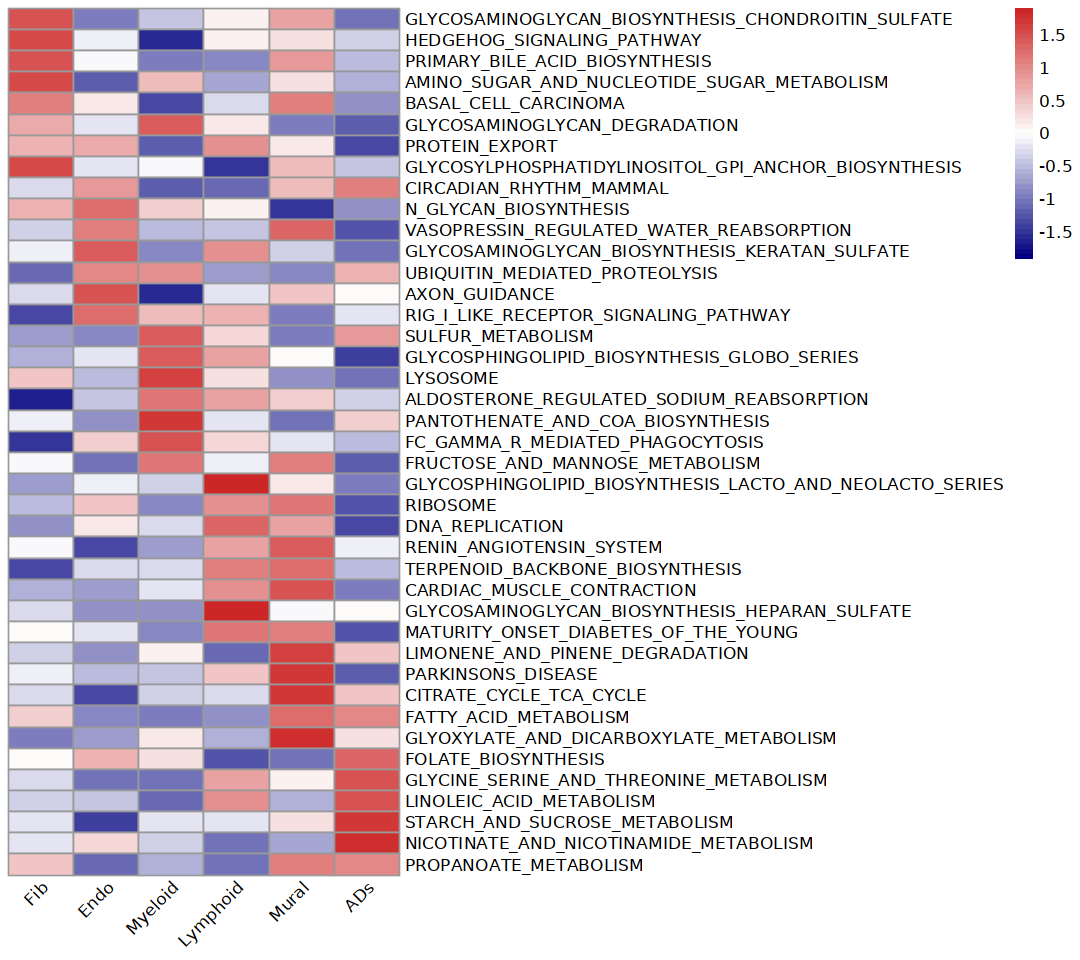

In [133]:
library(pheatmap)
pheatmap(as.matrix(gsva.kegg), scale = "row",angle_col = "45",cluster_cols  = FALSE,cluster_rows = FALSE,
        
        show_column_names = F,
        show_row_names = T,
         color = colorRampPalette(c("navy", "white", "firebrick3"))(50))
dev.off()

In [136]:
options(repr.plot.width = 9,repr.plot.height = 5)

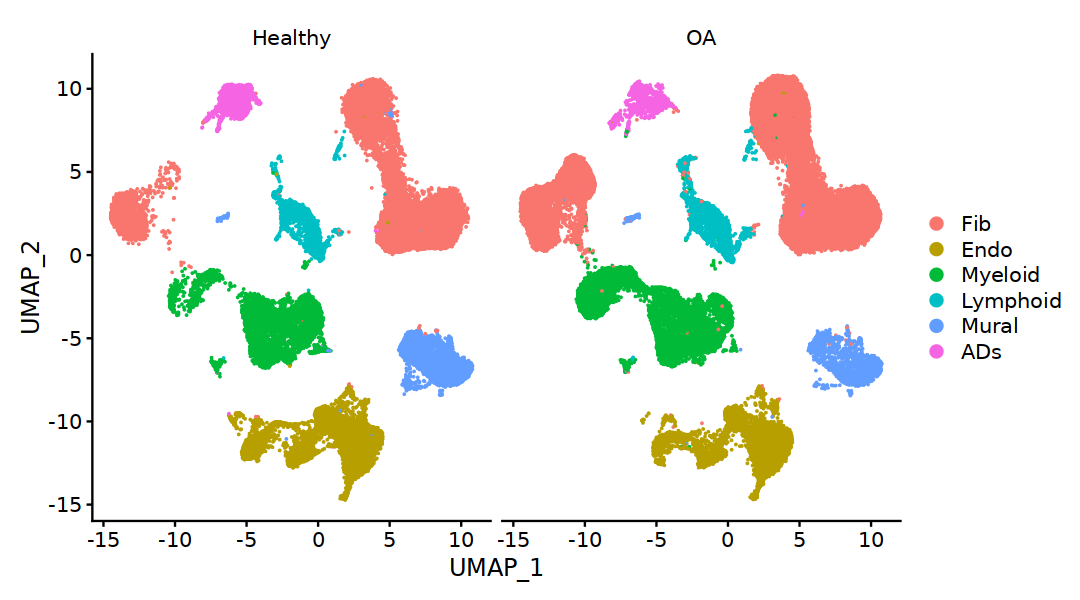

In [137]:
DimPlot(scRNA,split.by = 'group')

In [138]:
ggsave('../figure2/split.by.sample.pdf',width = 9,height = 5)

In [140]:
options(repr.plot.width = 14,repr.plot.height = 14)

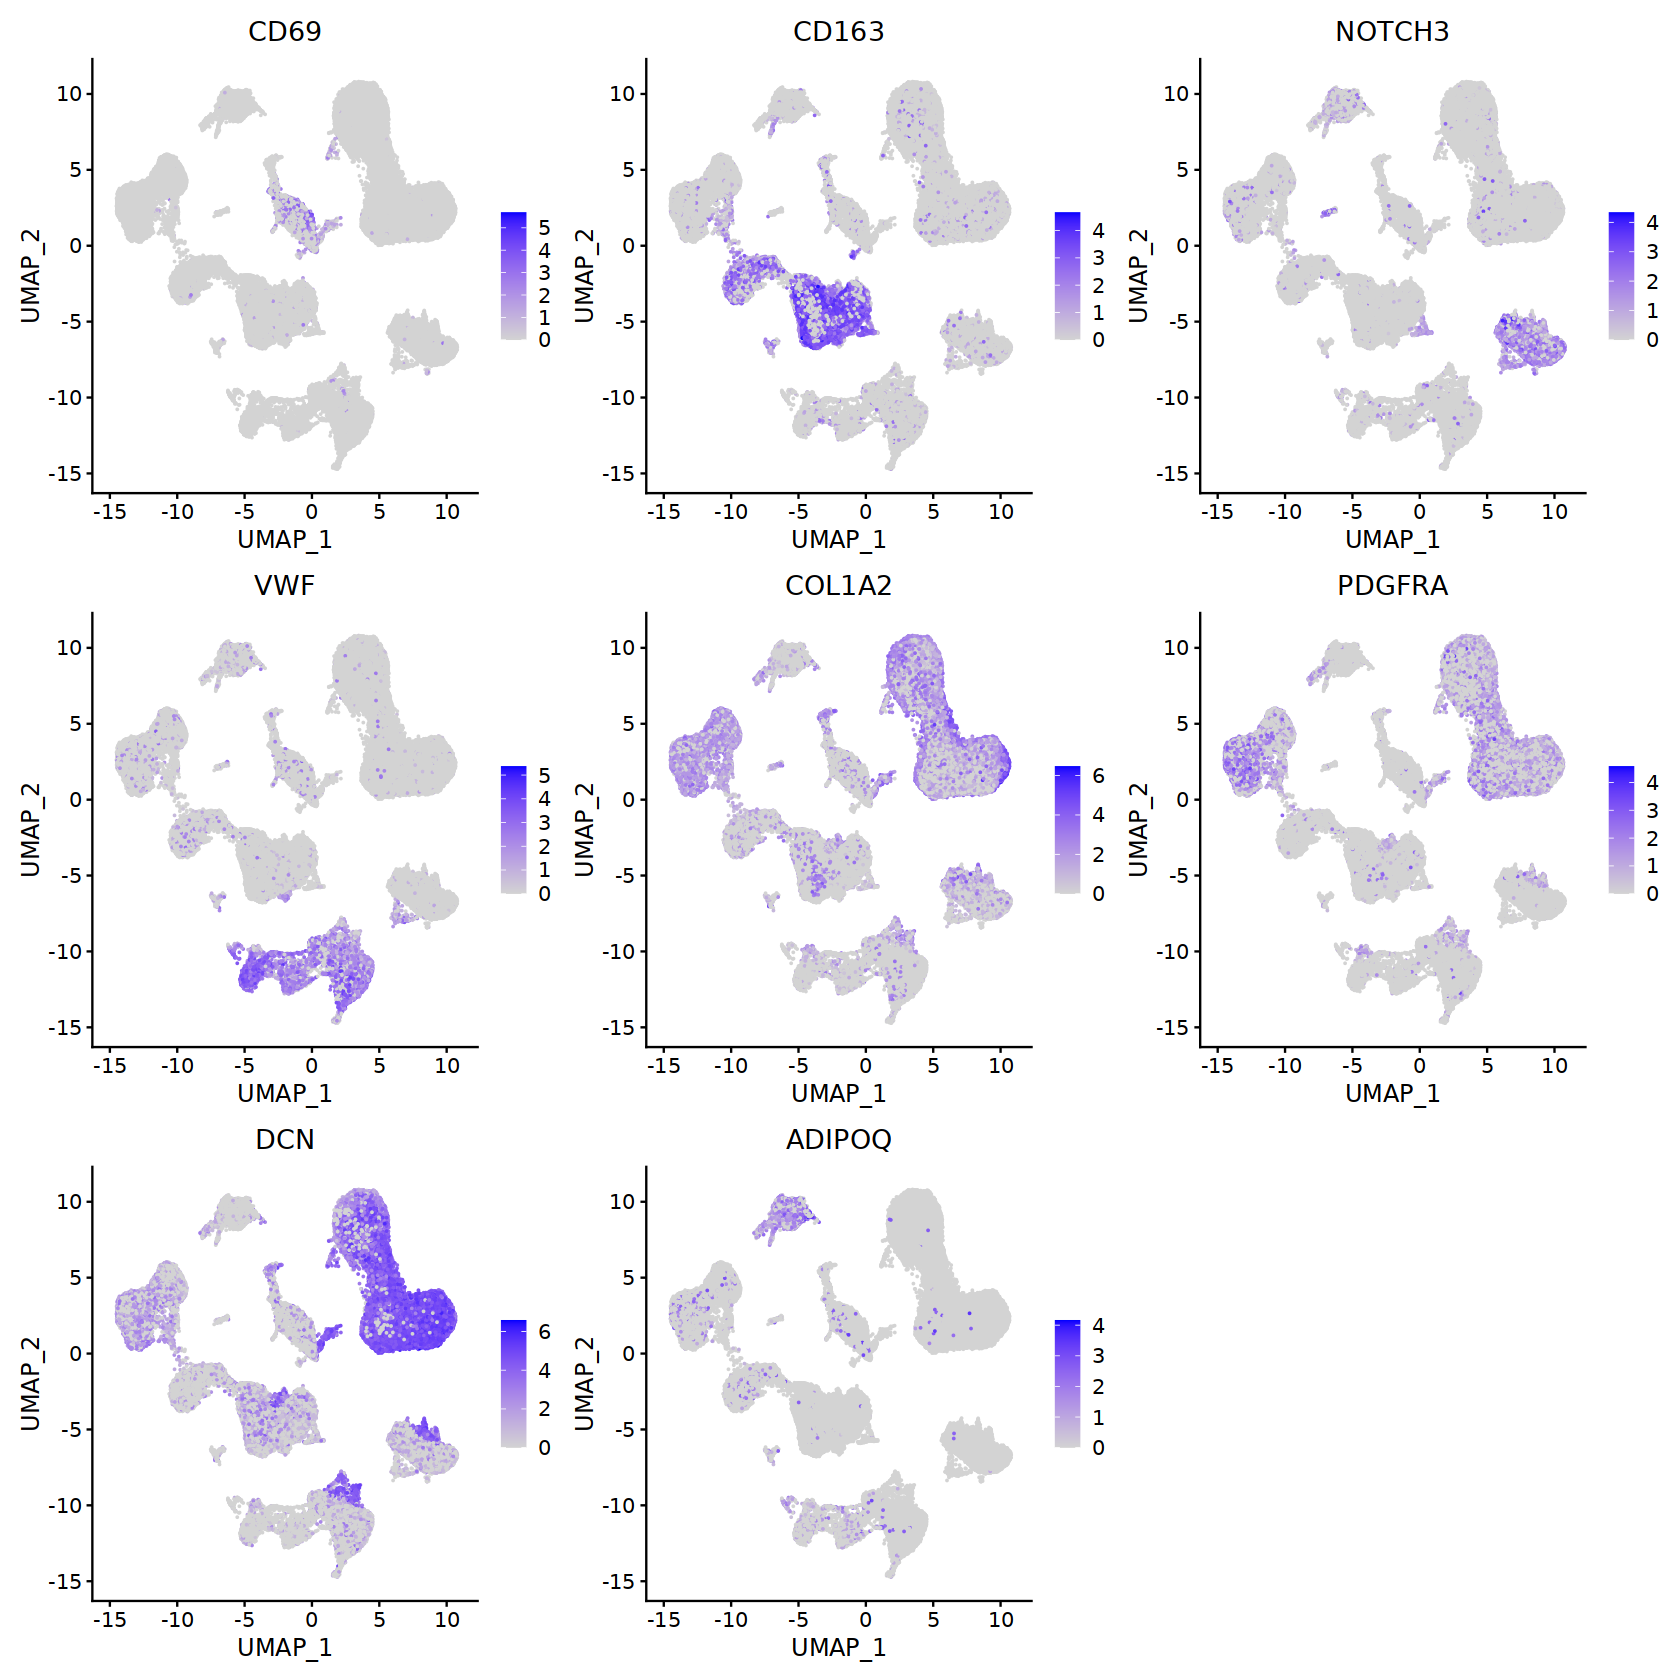

In [141]:
FeaturePlot(scRNA,features = c('CD69','CD163','NOTCH3','VWF','COL1A2','PDGFRA','DCN','ADIPOQ'))

In [142]:
ggsave('../figure2/marker.umap.pdf',width = 14,height = 15)

In [1]:
table(scRNA$celltype)
Idents(scRNA) = 'celltype'

ERROR: Error in table(scRNA$celltype): object 'scRNA' not found


In [119]:
endo = subset(scRNA,idents = 'Endo')

In [120]:
saveRDS(endo,file = 'endo.rds')

In [121]:
Macrophage = subset(scRNA,idents = c('Myeloid'))

In [122]:
saveRDS(Macrophage,file = 'Macrophage.rds')

In [126]:
fib = subset(scRNA,idents = 'Fib')

In [127]:
Mural = subset(scRNA,idents = 'Mural')

In [128]:
saveRDS(fib,file = 'fib.rds')

In [129]:
saveRDS(Mural,file = 'Mural.rds')

### lec 和spp1鑒定出來后

In [23]:
spp1 =  readRDS('./spp1.rds') 

In [24]:
LEC = readRDS('./LEC.rds')

In [25]:
scRNA@meta.data$celltype2 = ifelse(rownames(scRNA@meta.data) %in%  spp1 ,'SPP1_mac' ,scRNA@meta.data$celltype)

In [26]:
scRNA@meta.data$celltype3 = ifelse(rownames(scRNA@meta.data) %in%  LEC ,'LECs' ,scRNA@meta.data$celltype2)

In [27]:
table(scRNA@meta.data$celltype3)


           B_cell      Chondrocytes Endothelial_cells              LECs 
              102             19333              4756                61 
       Macrophage          Monocyte           NK_cell          SPP1_mac 
             3498              1635               611               100 
          T_cells Tissue_stem_cells 
             1812              5792 

In [28]:
saveRDS(scRNA,file = 'scrna.rds')

In [2]:
scRNA = readRDS('./scrna.rds')

Warning message in gzfile(file, "rb"):
"cannot open compressed file './scrna.rds', probable reason 'No such file or directory'"


ERROR: Error in gzfile(file, "rb"): cannot open the connection


In [6]:
library(Seurat)

Warning message:
"package 'Seurat' was built under R version 4.2.3"
Attaching SeuratObject



In [107]:
Idents(scRNA) = 'celltype'

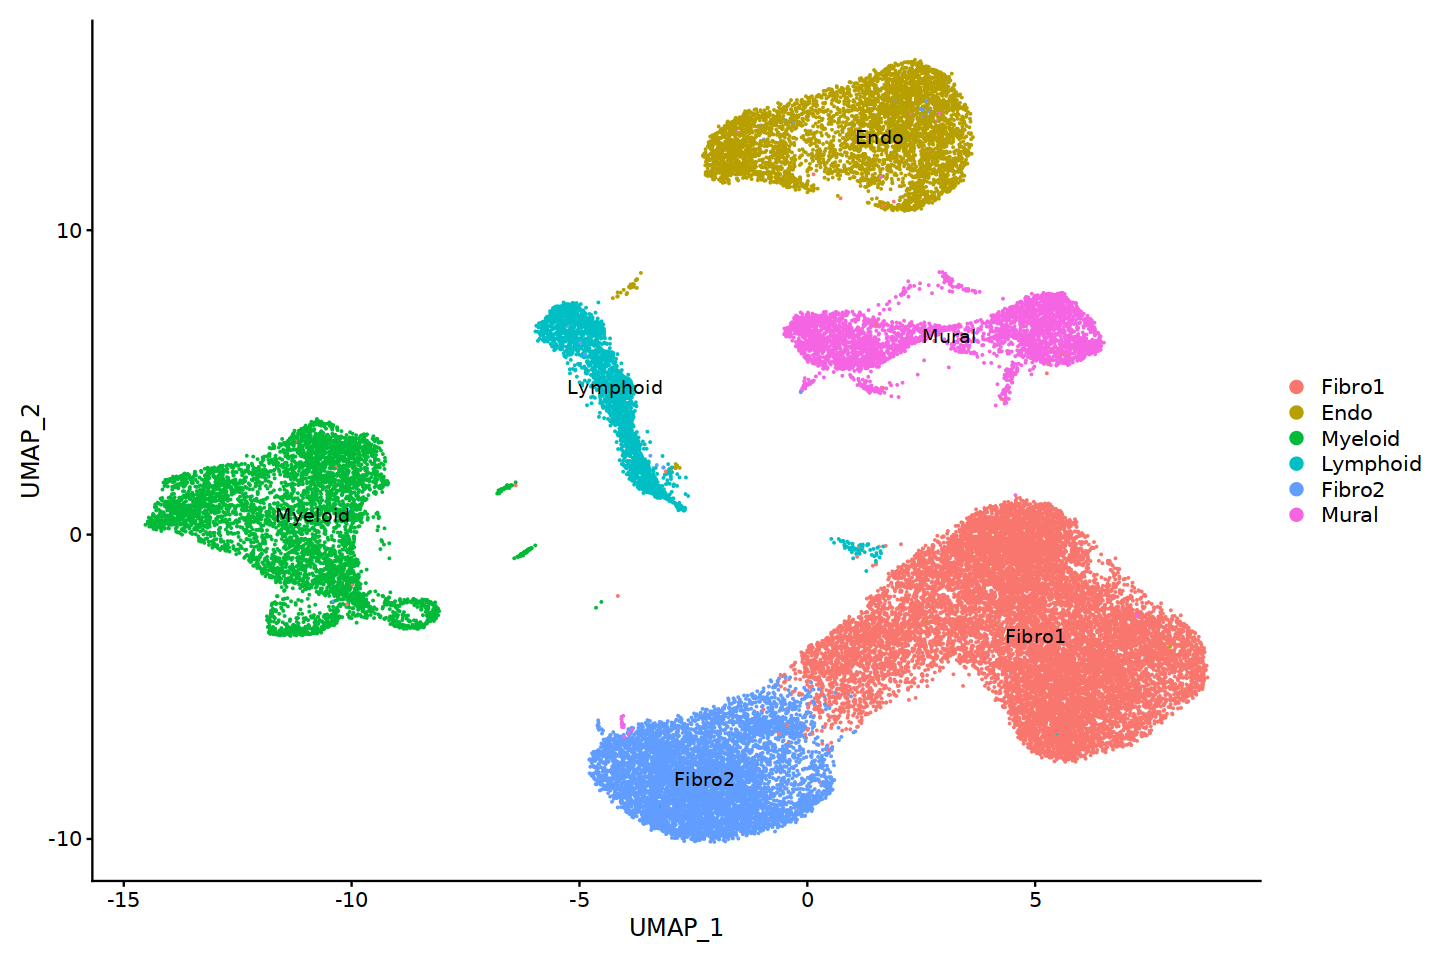

In [108]:
DimPlot(scRNA,label = T)

In [17]:
Idents(scRNA) = 'celltype3'

In [18]:
LEC = subset(scRNA,idents = 'LECs')